# Implementation of a LSTM network

In [31]:
# reset variables
%reset -f

# import external modules
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc 
from datetime import datetime
from tabulate import tabulate
from decimal import Decimal

import keras
print("keras.__version__ =", keras.__version__ )
from keras import layers, regularizers, Input, Model
from keras.optimizers import RMSprop, Adam, Nadam
from keras.initializers import RandomUniform
from keras.models import Sequential
from keras import backend as K

import tensorflow as tf
tf.set_random_seed(100)
print("tf.__version__ =", tf.__version__)
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from functions import MAE, RMSE, split_dataset

keras.__version__ = 2.2.4
tf.__version__ = 1.12.0


In [32]:
# Set global paths
ROOT_PATH = os.path.abspath(".").split("src")[0]

# configure matplotlib params and plotting
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

rc('figure', figsize=(12,6))
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=13, titlesize=14)
rc('legend', fontsize=14, handlelength=2)
rc('font', family='serif')

SEED=100
np.random.seed(SEED)

### Load data

In [33]:
path = ROOT_PATH + "data/dataframes/"
df_train = pd.read_pickle(path + "df_scaled_train.pkl")
df_valid = pd.read_pickle(path + "df_scaled_valid.pkl")
df_test = pd.read_pickle(path + "df_scaled_test.pkl")

USE_DUMMY_DATA = False
if USE_DUMMY_DATA: 
    num_obs = 10000  # 5000, 10000 or 25000
    path = ROOT_PATH + "data/dummy/"
    df_train = pd.read_pickle(path + "dummy_train_{0}.pkl".format(num_obs))
    df_valid = pd.read_pickle(path + "dummy_valid_{0}.pkl".format(num_obs))
    df_test = pd.read_pickle(path + "dummy_test_{0}.pkl".format(num_obs))

# splitting into training, testing and validation sets
x_train, y_train = split_dataset(df_train.values, delay=1)
x_valid, y_valid = split_dataset(df_valid.values, delay=1)
x_test, y_test = split_dataset(df_test.values, delay=1)

# reading metadata
path = ROOT_PATH + "data/metadata/"

# stats for scaling
stats = pd.read_csv(path+"stats.csv", sep=",")

# tags
headers = df_train.columns.values
target_tags = headers[:3]
feature_tags = headers[3:]

# timestamps
ts = np.load(path + "timestamps/dtimestamps.npy")
ts_train = np.load(path + "timestamps/ts_train.npy")
ts_valid = np.load(path + "timestamps/ts_valid.npy")
ts_test = np.load(path + "timestamps/ts_test.npy")

print(df_train.shape, df_valid.shape, df_test.shape)
print(x_train.shape, y_train.shape)

(53211, 21) (17737, 21) (17737, 21)
(53210, 18) (53210, 3)


In [34]:
selected_features = [
   "VAL_23_ZT_92543:Z.X.Value",
   "VAL_23-PT-92523:X.Value",
   "VAL_23-PDT-92534:X.Value",
   "VAL_23_TT_92532:Z.X.Value",
   "VAL_23-TIC-92504:Z.X.Value",
   "VAL_23_KA_9101_M01_62C:Z.X.Value"
]

keep_idxs = [list(feature_tags).index(tag) for tag in selected_features]

x_train = x_train[:,keep_idxs]
x_valid = x_valid[:,keep_idxs]
x_test = x_test[:,keep_idxs]

print(df_train.shape, df_valid.shape, df_test.shape)
print(x_train.shape, y_train.shape)

(53211, 21) (17737, 21) (17737, 21)
(53210, 6) (53210, 3)


# _________________________ 

# Functions

In [35]:
def batch_generator(x_data, y_data, lookback, batch_size=128):
    """
    Generator function for creating random batches of training-data.
    
    :param x_data: Numpy array of the features, not targets. 2D array, normalized/scaled, numpy.
    :param y_data: Numpy array of the targets, not features. 2D array, normalized/scaled, numpy. 
    :param lookback: How many timesteps back the input data should go.
    :param batch_size: The number of samples per batch.
    """
    num_x_signals = x_data.shape[1]
    num_y_signals = y_data.shape[1]

    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, lookback, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, lookback, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(x_data.shape[0] - lookback)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_data[idx:idx+lookback]
            y_batch[i] = y_data[idx:idx+lookback]
        
        yield (x_batch, y_batch)

In [36]:
def plot_history(history, savepath=None):
    """
    Plots the training and validation loss history of the model in the training phase. 
    """
    epochs = history.epoch

    train_mae = history.history['loss']
    val_mae = history.history['val_loss']

    plt.figure()
    plt.plot(epochs, train_mae, marker='o', markersize='3.0', label=r'Training loss', color="darkred")
    plt.plot(epochs, val_mae, marker='o', markersize='3.0', label=r'Validation loss', color="darkblue")  
    plt.xlabel(r'Epoch')
    plt.ylabel(r'MAE')
    plt.legend(frameon=True)
    if savepath is not None: 
        plt.savefig(savepath)
    plt.show()

In [37]:
def make_n_predictions(model, x_data, y_data, nruns=50):
    """
    Make n predictions with a specified trained model. 
    """
    x = np.expand_dims(x_data, axis=0)
    y_true = y_data
    
    preds_matr = np.zeros(shape=(nruns,y_true.shape[0],y_true.shape[1])) # (nruns, predictions, num_targets)
    err_matr = np.zeros(shape=(nruns, y_true.shape[1]))  # (nruns, num_targets) - one error per target per run

    for run in range(nruns):
        preds = model.predict(x)[0]
        err = MAE(y_true, preds, vector=True)
        
        preds_matr[run] = preds
        err_matr[run] = err
    
    pred_means = np.array([np.mean(preds_matr[:,:,i], axis=0) for i in range(y_data.shape[-1])]).T
    pred_stds = np.array([np.std(preds_matr[:,:,i], axis=0) for i in range(y_data.shape[-1])]).T
    
    return preds_matr, err_matr

In [38]:
def plot_multiple_predictions(preds_matr, y_true, time_vec, target_tags, 
                              start_idx=0, n_obs=200, plotCI=False, savepath=None):
    """
    Plots different realisations of the model, alternatively a 95% CI interval. 
    :param preds_matr: 3D matrix - The "predictions matrix" as obtained by the function make_n_predictions.
    :param y_true: 2D matrix - The true target values, matrix of all targets. 
    :param start_idx: Integer - The start index the plot should start at.
    :param plotCI: Boolean - If a CI interval should be plotted. 
    
    :return None: Will only show the obtained plot. 
    """
    pred_means = np.array([np.mean(preds_matr[:,:,i], axis=0) for i in range(y_true.shape[-1])]).T
    pred_stds = np.array([np.std(preds_matr[:,:,i], axis=0) for i in range(y_true.shape[-1])]).T
    nruns = preds_matr.shape[0]
    
    start_idx = start_idx if start_idx < len(y_true) else max(0,len(y_true)-n_obs) 
    end_idx = min(len(y_true),start_idx+n_obs)
    
    time = time_vec[start_idx:end_idx]
    
    for output in range(preds_matr.shape[-1]):
        
        plt.figure()
        
        if not plotCI: # then plot individual predictions 
            for run in range(nruns):
                preds = preds_matr[run, start_idx:end_idx, output]
                plt.plot_date(time, preds, alpha=0.3, color="gray", markersize=0, linestyle="-")
        else: 
            z = 1.96 #95% CI
            CI_low = np.subtract(pred_means,pred_stds*z)
            CI_high = np.add(pred_means,pred_stds*z)
            plt.fill_between(time,
                             CI_low[start_idx:end_idx,output], CI_high[start_idx:end_idx,output], 
                             color="gray", alpha=0.5, label="95% CI")
    
        y_pred_mean = pred_means[start_idx:end_idx,output]
        y_signal_true = y_true[start_idx:end_idx, output]
        
        plt.plot_date(time, y_pred_mean, color="darkblue", linewidth=1.5, linestyle="-", markersize=0, label="Mean prediction")
        plt.plot_date(time, y_signal_true, color="darkred", linewidth=1.5, linestyle="-", markersize=0, label="True")
        plt.ylabel(target_tags[output])
        plt.legend(frameon=True)
        if savepath is not None:
            spl = savepath.split(".")
            plt.savefig(spl[0] + "_{0}".format(output) + "." + spl[1])
        plt.show()

In [39]:
def evaluate_model(model, x_train, y_train, x_valid, y_valid, x_test, y_test, 
                   name, means, stds, root_path, feature_tags, target_tags,
                   optimizer, generator, lookback=540, batch_size=256, epochs=30, loss='mae', nruns=40, makeplots=True):
    """
    Will train the model and output model performance on validation data.
    """
    
    
    model_folder = root_path + "models/{0}/{1}/".format(name,epochs)
    if not os.path.exists(model_folder):
        print("Creating directory", model_folder)
        os.makedirs(model_folder)
    
    path_checkpoint = model_folder + "weights.keras".format(name)
    callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                          monitor='val_loss',
                                          verbose=1,
                                          save_weights_only=True,
                                          save_best_only=True)
    
    '''
    callback_reducelr = ReduceLROnPlateau(monitor = 'val_loss', 
                                          factor = 0.5,
                                          min_lr=0.001,
                                          patience = 3, 
                                          verbose = 0)
    
    #callbacks = [callback_checkpoint, callback_reducelr]
    '''
    callbacks = [callback_checkpoint]
    
    train_gen = generator(x_train, y_train, lookback, batch_size)
    model.compile(loss=loss, optimizer=optimizer)
    
    # train the model
    train_steps = int(x_train.shape[0] // batch_size)
    validation_data = (np.expand_dims(x_valid, axis=0),
                       np.expand_dims(y_valid, axis=0))
    
    history = model.fit_generator(generator=train_gen,
                                  epochs=epochs,
                                  steps_per_epoch=train_steps,
                                  validation_data=validation_data,
                                  callbacks=callbacks)
    
    # save the model 
    model.save(model_folder + "model.h5".format(name))
    
    # plot history of training and validation loss
    if makeplots:
        plot_history(history, model_folder + "history.png".format(name))
    
    # load the weights that gave the best validation error
    model.load_weights(path_checkpoint)
    
    # define some properties that we'll need
    target_stds = stds[x_train.shape[1]:]
    num_features = y_train.shape[-1]
    
    
    # == VALIDATION DATA == #
    ## Get the respecitve MAEs for each output
    preds_val, errs_val = make_n_predictions(model, x_valid, y_valid, nruns)
    mean_preds_val = np.array([np.mean(preds_val[:,:,i], axis=0) for i in range(num_features)]).T
    stds_preds_val = np.array([np.std(preds_val[:,:,i], axis=0) for i in range(num_features)]).T 
    expected_std_val = np.mean(stds_preds_val,axis=0)   # the expected standard deviation of the predictions
    expected_mean_val = np.mean(mean_preds_val,axis=0)  # the expected mean of the predictions

    mae_val = np.mean(errs_val,axis=0)    # the mean standardized validation error for each target
    mae_val_unstd = mae_val*target_stds   # the mean unstandardized validation error for each target
    avg_mae_val = np.mean(mae_val)        # the single average of all mean validation errors
    avg_mae_val_unstd = np.mean(mae_val_unstd)

    ## collect in a dataframe
    columns = ["Tag", "MAE (std)", "MAE (unstd)", "Expect. Mean", "Expect. Stdev"]
    df_val = pd.DataFrame(np.column_stack([target_tags, mae_val, mae_val_unstd, expected_mean_val, expected_std_val]), 
                          columns=columns)
    df_val.loc[len(df_val)] = ['Average', avg_mae_val, avg_mae_val_unstd, np.mean(expected_mean_val), np.mean(expected_std_val)]
    str_table_val = tabulate(df_val, headers='keys', tablefmt='psql', floatfmt='.5f')

    dict_val = {
        'df':df_val,
        'str_table':str_table_val,
        'predictions_matrix': preds_val,
        'predictions_mean': mean_preds_val,
        'predictions_stds': stds_preds_val,
    }
    print("\n       Validation data")
    print(str_table_val)
    
    
    # == TEST DATA == #
    ## Get the respecitve MAEs for each output
    preds_test, errs_test = make_n_predictions(model, x_test, y_test, nruns)
    mean_preds_test = np.array([np.mean(preds_test[:,:,i], axis=0) for i in range(num_features)]).T
    stds_preds_test = np.array([np.std(preds_test[:,:,i], axis=0) for i in range(num_features)]).T 
    expected_std_test = np.mean(stds_preds_test,axis=0)   # the expected standard deviation of the predictions
    expected_mean_test = np.mean(mean_preds_test,axis=0)  # the expected mean of the predictions

    mae_test = np.mean(errs_test,axis=0)    # the mean standardized validation error for each target
    mae_test_unstd = mae_test*target_stds   # the mean unstandardized validation error for each target
    avg_mae_test = np.mean(mae_test)         # the single average of all mean validation errors
    avg_mae_test_unstd = np.mean(mae_test_unstd)

    ## collect in a dataframe
    columns = ["Tag", "MAE (std)", "MAE (unstd)", "Expect. Mean", "Expect. Stdev"]
    df_test = pd.DataFrame(np.column_stack([target_tags, mae_test, mae_test_unstd, expected_mean_test, expected_std_test]), 
                          columns=columns)
    df_test.loc[len(df_test)] = ['Average', avg_mae_test, avg_mae_test_unstd, np.mean(expected_mean_test), np.mean(expected_std_test)]
    str_table_test = tabulate(df_test, headers='keys', tablefmt='psql', floatfmt='.5f')
    
    dict_test = {
        'df':df_test,
        'str_table':str_table_test,
        'predictions_matrix': preds_test,
        'predictions_mean': mean_preds_test,
        'predictions_stds': stds_preds_test,
    }
    print("\n       Testing data")
    print(str_table_test)
    
    # Save files
    np.save(model_folder + "targets_valid.npy", y_valid)
    np.save(model_folder + "targets_test.npy", y_test)
    np.save(model_folder + "predictions_valid.npy", preds_val)
    np.save(model_folder + "predictions_test.npy", preds_test)
    df_val.to_pickle(model_folder + "dfval.pkl")
    df_test.to_pickle(model_folder + "dftest.pkl")
    np.save(model_folder + "table_valid.npy", str_table_val)
    np.save(model_folder + "table_test.npy", str_table_test)

    # If makeplots = True, then plot the predictions with the mean 
    if makeplots: 
        plot_multiple_predictions(preds_val, y_valid, plotCI=True, 
                                  savepath=model_folder+"{0}_uncertainty_plots.png".format(name))
    
    return_dict = {
        'model': model,
        'history': history,
        'validation': dict_val,
        'test': dict_test,
    }
    
    return return_dict

In [40]:
def make_summary_for_dict(model_dict, y_valid, time_valid, y_test, time_test, target_tags, start_idx=2000, n_obs=6*60):
    model_dict['model'].summary()

    print("\n      Validation data")
    print(model_dict['validation']['str_table'])

    print("\n      Testing data")
    print(model_dict['test']['str_table'])
    
    print("\n Some sample plots:")
    print("---- Training vs validation history ----")
    plot_history(model_dict['history'])
    
    print("---- Plots of the predictions vs true ----")
    print("Validation data")
    plot_multiple_predictions(model_dict['validation']['predictions_matrix'],
                             y_valid, time_valid, target_tags, start_idx,n_obs, plotCI=False)
    
    print("Test data")
    plot_multiple_predictions(model_dict['test']['predictions_matrix'],
                         y_test, time_test, target_tags, start_idx,n_obs, plotCI=False)
    
    print("--- Plots with CI intervals ---")
    print("Validation data")
    plot_multiple_predictions(model_dict['validation']['predictions_matrix'],
                             y_valid, time_valid, target_tags, start_idx,n_obs, plotCI=True)
    
    print("Test data")
    plot_multiple_predictions(model_dict['test']['predictions_matrix'],
                         y_test, time_test, target_tags, start_idx,n_obs, plotCI=True)

In [41]:
def get_df_from_dicts(dicts, columns, index, texpath=None, round_digits=4):
    """
    Will make a dataframe with error metrics for each target tag out of a collection of dictionaries 
    as obtained by evaluate_model(). The model names will be collected as indexes in the dataframe, and the 
    target errors in the columns. 
    """
    
    val_maes = []
    test_maes = []
    for d in dicts:
        tmp_mae_val = [round(float(digit),round_digits) for digit in d['validation']['df']['MAE (std)'].tolist()]
        tmp_mae_test = [round(float(digit),round_digits) for digit in d['test']['df']['MAE (std)'].tolist()]

        val_maes.append(tmp_mae_val)
        test_maes.append(tmp_mae_test)

    # make df
    df_val = pd.DataFrame(np.vstack(val_maes), index=index, columns=columns)
    df_test = pd.DataFrame(np.vstack(test_maes), index=index, columns=columns)
    df_summary = pd.concat([df_val, df_test], axis=1, keys=["Validation", "Test"])

    tex = df_summary.to_latex(column_format="l" + "c"*(len(columns)*2),
                              multicolumn=True, 
                              multicolumn_format='c', 
                              bold_rows=True)
    if texpath is not None: 
        with open(texpath) as f:
            f.write(tex)

    return df_summary, tex

In [42]:
def get_uncertainty_df_from_dicts(dicts, columns, index, levels, texpath=None, round_digits=4):
    """
    Will make a dataframe with uncertainty and error metrics for each target tag out of a collection of dictionaries 
    as obtained by evaluate_model().
    """
    
    dataframes = []
    for d in dicts:
        df = d['validation']
        avg_maes = [round(float(digit),round_digits) for digit in df['df']['MAE (std)'].tolist()]
        exp_means = [round(float(digit),round_digits) for digit in df['df']['Expect. Mean'].tolist()]
        exp_stds = [round(float(digit),round_digits) for digit in df['df']['Expect. Stdev'].tolist()]
        df_1 = pd.DataFrame(np.column_stack([avg_maes, exp_means, exp_stds]), index = levels, columns = columns)

        df = d['test']
        avg_maes = [round(float(digit),round_digits) for digit in df['df']['MAE (std)'].tolist()]
        exp_means = [round(float(digit),round_digits) for digit in df['df']['Expect. Mean'].tolist()]
        exp_stds = [round(float(digit),round_digits) for digit in df['df']['Expect. Stdev'].tolist()]
        df_2 = pd.DataFrame(np.column_stack([avg_maes, exp_means, exp_stds]), index = levels, columns = columns)
        df_concat = pd.concat([df_1, df_2], axis=1, keys=["Validation", "Test"])
        dataframes.append(df_concat)
    
    summary_df = pd.concat(dataframes, axis=0, keys=index)
    
    tex = summary_df.to_latex(column_format="ll" + "c"*(len(columns)*2),
                              multicolumn=True, 
                              multicolumn_format='c',
                              multirow=True,
                              bold_rows=True)

    if texpath is not None: # save the file
        with open(texpath, 'w+') as f:
            f.write(tex)
    
    return summary_df, tex

# Implementation

In [43]:
def lstm_architecture_2(input_layer, num_output_signals):  
    layer_1 = layers.LSTM(128,
                         dropout = 0.2,
                         recurrent_dropout = 0.2,
                         return_sequences = True)(input_layer, training=True)

    output_layer = layers.Dense(num_output_signals)(layer_1)
    
    model = Model(input_layer, output_layer) 
    return model

In [ ]:
K.clear_session()
input_layer = Input(shape=(None,x_train.shape[-1]))
architecture = lstm_architecture_2(input_layer, y_train.shape[-1])
name = "lstm_128"

epochs=30

means = stats["Mean"].values
stds = stats["Std"].values

lstm_128_dict = evaluate_model(architecture, 
                               x_train, y_train, 
                               x_valid, y_valid, 
                               x_test, y_test, 
                               name, 
                               means,
                               stds, 
                               ROOT_PATH, 
                               feature_tags, 
                               target_tags, 
                               optimizer=Adam(), 
                               generator=batch_generator,
                               epochs=epochs, 
                               makeplots=False)

Epoch 1/30
207/207 [==============================] - 146s 706ms/step - loss: 0.4935 - val_loss: 0.5589

Epoch 00001: val_loss improved from inf to 0.55891, saving model to /home/shomeb/h/halvorre/master-thesis/models/lstm_128/30/weights.keras
Epoch 2/30
207/207 [==============================] - 147s 712ms/step - loss: 0.4229 - val_loss: 0.5070

Epoch 00002: val_loss improved from 0.55891 to 0.50700, saving model to /home/shomeb/h/halvorre/master-thesis/models/lstm_128/30/weights.keras
Epoch 3/30
207/207 [==============================] - 147s 712ms/step - loss: 0.4064 - val_loss: 0.4657

Epoch 00003: val_loss improved from 0.50700 to 0.46567, saving model to /home/shomeb/h/halvorre/master-thesis/models/lstm_128/30/weights.keras
Epoch 4/30
207/207 [==============================] - 148s 713ms/step - loss: 0.3955 - val_loss: 0.4382

Epoch 00004: val_loss improved from 0.46567 to 0.43818, saving model to /home/shomeb/h/halvorre/master-thesis/models/lstm_128/30/weights.keras
Epoch 5/30
2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 18)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         75264     
_________________________________________________________________
dense_1 (Dense)              (None, None, 3)           387       
Total params: 75,651
Trainable params: 75,651
Non-trainable params: 0
_________________________________________________________________

      Validation data
+----+----------------------------+-------------+---------------+----------------+-----------------+
|    | Tag                        |   MAE (std) |   MAE (unstd) |   Expect. Mean |   Expect. Stdev |
|----+----------------------------+-------------+---------------+----------------+-----------------|
|  0 | VAL_23-FT-92537-01:X.Value |     0.66265 |     107.34234 |       -0.0

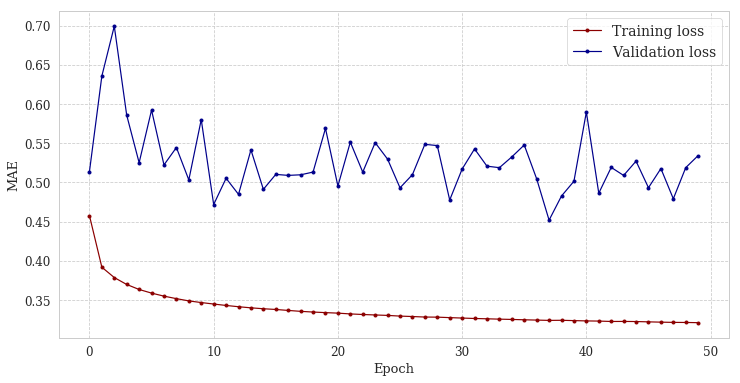

---- Plots of the predictions vs true ----
Validation data


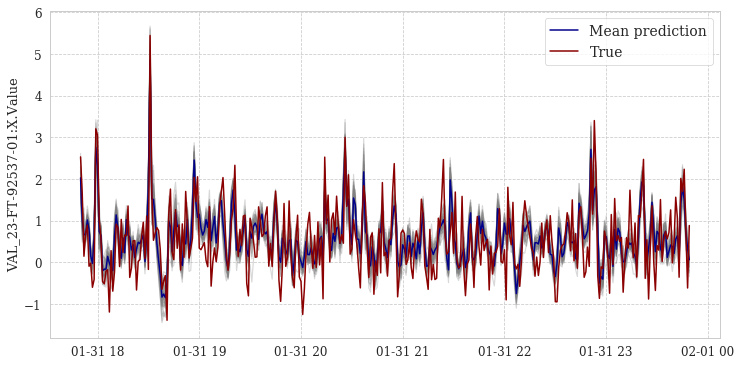

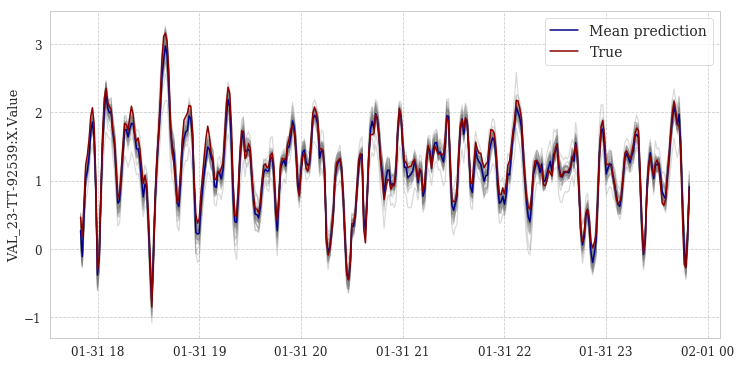

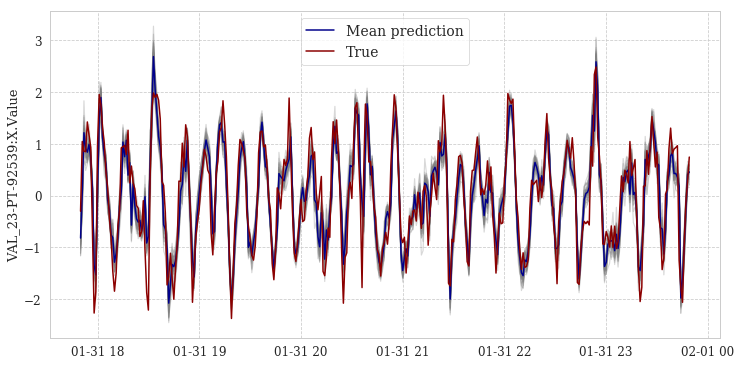

Test data


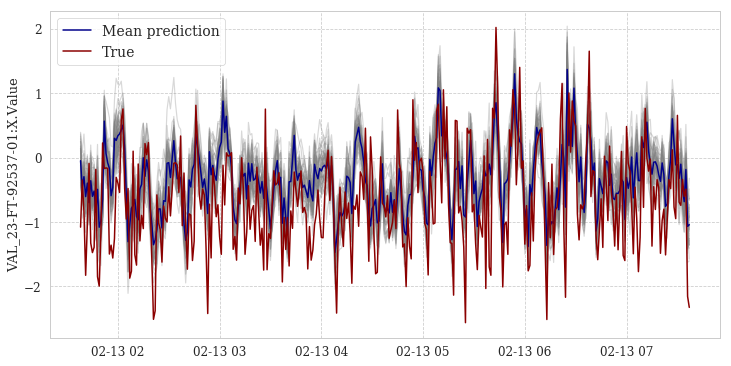

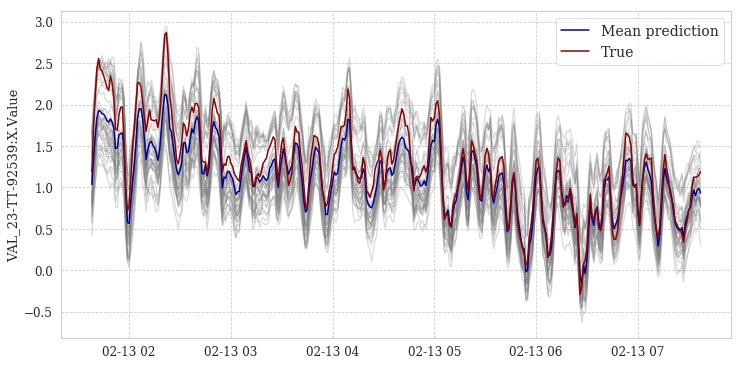

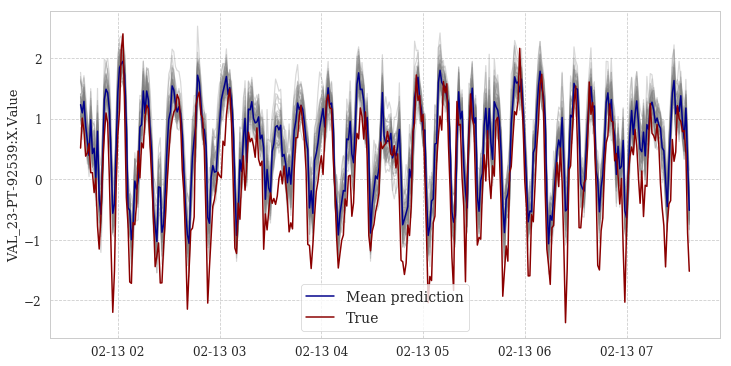

--- Plots with CI intervals ---
Validation data


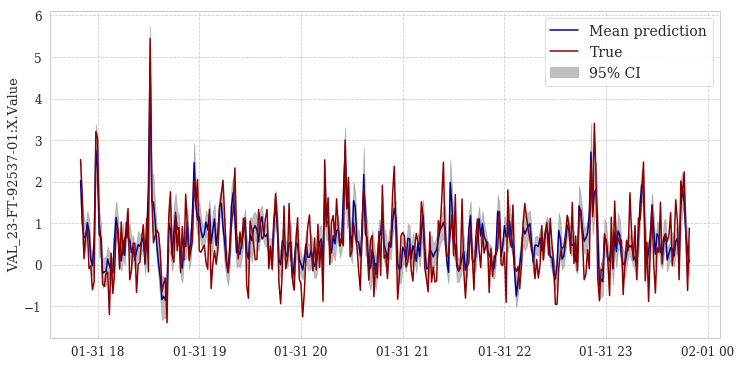

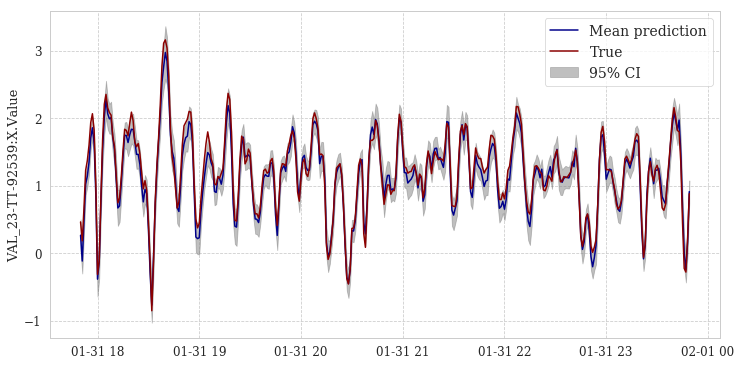

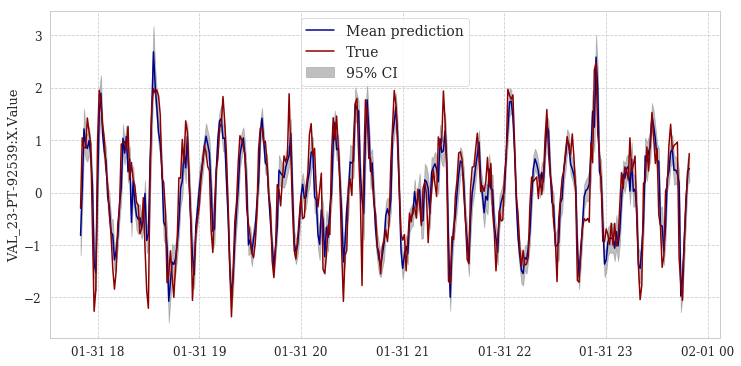

Test data


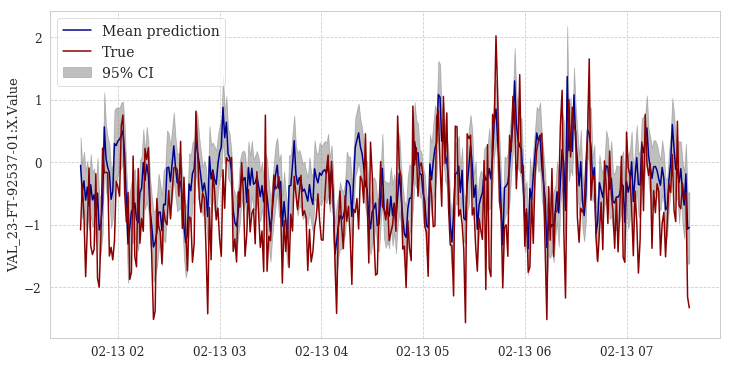

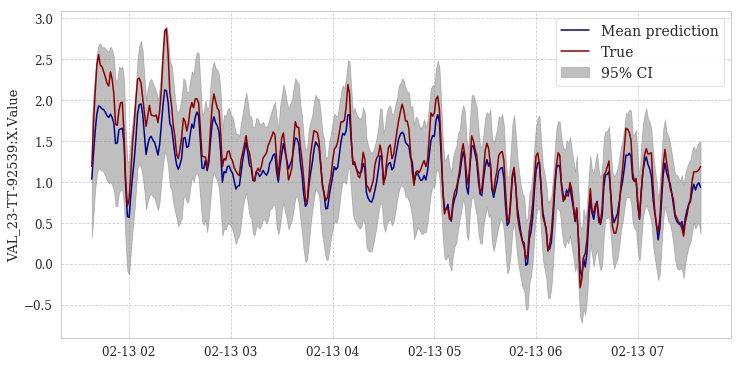

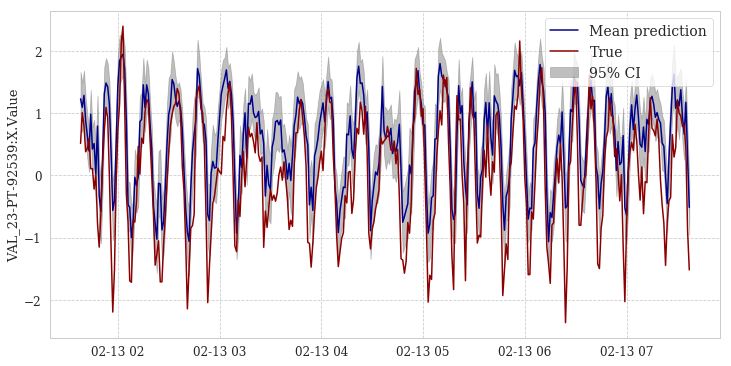

In [25]:
make_summary_for_dict(lstm_128_dict, y_valid, ts_valid, y_test, ts_test, target_tags)